3D Subduction from OzBench et al 2008
======

Use this setup to run the Underworld benchmark from [OzBench et al, 2008](http://www.sciencedirect.com/science/article/pii/S0031920108002318) (Figure 3b).

The Ozbench benchmark is used to compare 3D subduction models. The benchmark tests the ability to reproduce the deformation and retreat velocity of a single "slab" foundering in a large box of viscous fluid.

Viscous/plastic and viscoelastic/plastic models are catered for, with the appropriate equivalent parameter choices.  The upper surface can be free-slip (no vertical movement) or a moving, stress-free interface. In the former case, some plasticity in the near-surface is needed to allow the slab to bend and detach from the surface. The Underworld example is for a slab with a viscous core and viscoplastic upper and lower layers and a free-slip upper boundary.

The 3D subduction model has a dense, high viscosity 3 layered plate overlying a lower viscosity mantle. The upper and lower plate layers have a visco-plastic rheology, yielding under large stresses. The middle, core layer has a viscous only rheology, maintaining strength during bending. The top 1000 km of the mantle is included, the upper & lower mantle is partitioned with a viscosity contrast of 100x at 600 km depth. The velocity boundary conditions on the domain are free-slip. 

**References**

1. OzBench, M.; Regenauer-Lieb, K.; Stegman, D. R.; Morra, G.; Farrington, R.; Hale, A.; May, D. A.; Freeman, J.; Bourgouin, L.; Mühlhaus, H. & Moresi, L. A model comparison study of large-scale mantle-lithosphere dynamics driven by subduction. Physics of the Earth and Planetary Interiors, 2008, 171, 224-234. [OzBench, 2008](http://www.sciencedirect.com/science/article/pii/S0031920108002318)

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np
import os

In [2]:
outputPath = os.path.join(os.path.abspath("."),"output/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

**Setup parameters**


In [3]:
# use low resolution if running in serial
# use xRes = 96 to produce Fig 3b of OzBench (2008)
xRes = 16
yRes = xRes/2
zRes = xRes  
dim  = 3
boxLength = 6.0
boxHeight = 1.0
boxWidth  = 6.0


**Create mesh and finite element variables**

In [4]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes, zRes), 
                                 minCoord    = (0., 0., 0.), 
                                 maxCoord    = (boxLength, boxHeight, boxWidth)) 

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

**Create a particle swarm**

In [5]:
swarm = uw.swarm.Swarm( mesh=mesh )
materialVariable   = swarm.add_variable( dataType="int", count=1 )
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

**Allocate materials to particles**

In [6]:
# initialise the 'materialVariable' data to represent two different materials. 
upperMantleIndex = 0
lowerMantleIndex = 1
upperSlabIndex   = 2
lowerSlabIndex   = 3
coreSlabIndex    = 4

# Initial material layout has a flat lying slab with at 15\degree perturbation
slabWidth      = 3.0
lowerMantleY   = 0.4
slabLowerShape = np.array([ (3.0,0.925 ), (5.2,0.925 ), (5.2,0.900), (3.0,0.900), (2.82,0.825), (2.82,0.850) ])
slabCoreShape  = np.array([ (3.0,0.975 ), (5.2,0.975 ), (5.2,0.925), (3.0,0.925), (2.82,0.850), (2.82,0.900) ])
slabUpperShape = np.array([ (3.0,1.000 ), (5.2,1.000 ), (5.2,0.975), (3.0,0.975), (2.82,0.900), (2.82,0.925) ])

slabLower = fn.shape.Polygon( slabLowerShape )
slabUpper = fn.shape.Polygon( slabUpperShape )
slabCore  = fn.shape.Polygon( slabCoreShape )

# initialise everying to be upper mantle material
materialVariable.data[:] = upperMantleIndex

# change matieral index if the particle is not upper mantle
for index in range( len(swarm.particleCoordinates.data) ):
    coord = swarm.particleCoordinates.data[index][:]
    if coord[1] < lowerMantleY:
        materialVariable.data[index]     = lowerMantleIndex
    if coord[2] < slabWidth:
        if slabCore.evaluate(tuple(coord)):
            materialVariable.data[index] = coreSlabIndex
        if slabUpper.evaluate(tuple(coord)):
            materialVariable.data[index] = upperSlabIndex
        if slabLower.evaluate(tuple(coord)):
            materialVariable.data[index] = lowerSlabIndex
       

**Plot the initial material layout**

In [7]:
#First project material index on to mesh for use in plotting material isosurfaces
materialField = uw.mesh.MeshVariable( mesh, 1 )
projector = uw.utils.MeshVariable_Projection( materialField, materialVariable, type=0 )
projector.solve()


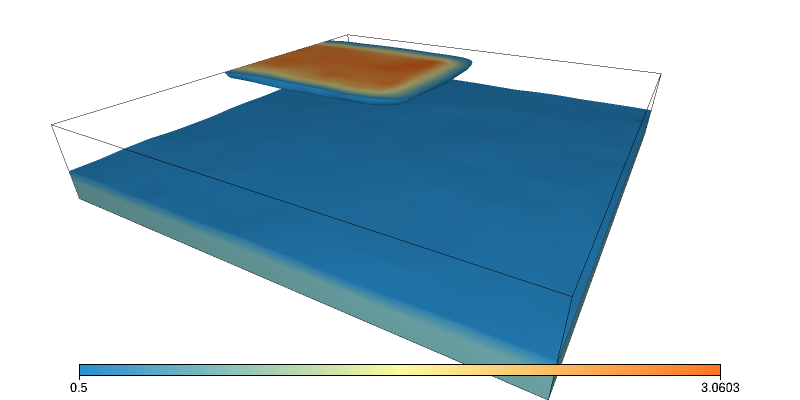

In [8]:
materialFilter = materialVariable > 0.5

figMaterialLayout = glucifer.Figure( figsize=(800,400), quality=2 )

#Points can be used to plot the materials but saving the swarm takes up a lot of space
#figMaterialLayout.Points(swarm, materialVariable, materialFilter, 
#                         pointSize=2, colourBar=False)

#A more efficient way is to use the IsoSurface object to extract just the boundaries
figMaterialLayout.IsoSurface( mesh, materialField, isovalues=[0.5], isowalls=True, shift=1)

#Example of adding cross sections at the boundaries
#figMaterialLayout.Surface( mesh, materialField, crossSection="x 100%", colourBar=False)
#figMaterialLayout.Surface( mesh, materialField, crossSection="z 0%", colourBar=False)

#Use a script to modify the camera view
camera = ['translate y 1', 'rotate y 60', 'rotate x 30', 'zoom 0.1']
figMaterialLayout.script(camera)

figMaterialLayout.show()

Set up material parameters and functions
----

Here the functions for viscosity, density, gravity and buoyancy are set. 

**Viscosity function**

The lower mantle is 100x more viscous than the upper mantle. The upper and lower slab layer weakens under high strain, it has a visco plastic rheology. The lower slab layer does not yield, it has a viscous rheology.  

In [9]:
upperMantleViscosity =    1.0
lowerMantleViscosity =  100.0
slabViscosity        =  200.0
coreViscosity        =  200.0

# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))
cohesion = 0.06
vonMises = 0.5 * cohesion / (strainRate_2ndInvariant+1.0e-18)

# The upper slab viscosity is the minimum of the 'slabViscosity' or the 'vonMises' 
slabYieldvisc = fn.exception.SafeMaths( fn.misc.min(vonMises, slabViscosity) )

# Viscosity function for the materials 
viscosityMap = { upperMantleIndex : upperMantleViscosity, 
                 lowerMantleIndex : lowerMantleViscosity, 
                 upperSlabIndex   : slabYieldvisc, 
                 lowerSlabIndex   : slabYieldvisc,
                 coreSlabIndex    : coreViscosity}
viscosityMapFn = fn.branching.map( fn_key = materialVariable, mapping = viscosityMap )

Set the density function, vertical unit vector and Buoyancy Force function


In [10]:
mantleDensity = 0.0
slabDensity   = 1.0 

densityMap = { upperMantleIndex : mantleDensity, 
               lowerMantleIndex : mantleDensity, 
               upperSlabIndex   : slabDensity, 
               lowerSlabIndex   : slabDensity, 
               coreSlabIndex    : slabDensity}
densityFn = fn.branching.map( fn_key = materialVariable, mapping = densityMap )

# Define our vertical unit vector using a python tuple
z_hat = ( 0., 1., 0. )

# now create a buoyancy force vector
buoyancyFn = -1.0 * densityFn * z_hat

**Set initial and boundary conditions**

In [11]:
# set initial conditions (and boundary values)
velocityField.data[:] = [0.,0.,0.]
pressureField.data[:] = 0.

# send boundary condition information to underworld
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
kWalls = mesh.specialSets["MinK_VertexSet"] + mesh.specialSets["MaxK_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls, kWalls) )

**System Setup**

In [12]:
# Initial linear slab viscosity setup
stokes = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               voronoi_swarm = swarm, 
                               conditions    = [freeslipBC,],
                               fn_viscosity   = viscosityMapFn, 
                               fn_bodyforce   = buoyancyFn )
# Create solver & solve
solver = uw.systems.Solver(stokes)

In [13]:
# use "lu" direct solve if running in serial
if(uw.nProcs()==1):
    solver.set_inner_method("lu")

In [14]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

**Analysis tools**

In [15]:
#The root mean square Velocity
velSquared = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )
area = uw.utils.Integral( 1., mesh )
Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )

**Set up visualisation of the particle swarm coloured by material type**

We are using a vis store object to keep all our figures together and allow them to be revisualised later so create this here and pass it to all the figures created later. We'll also name this figure to make it easy to find later when revisualising.


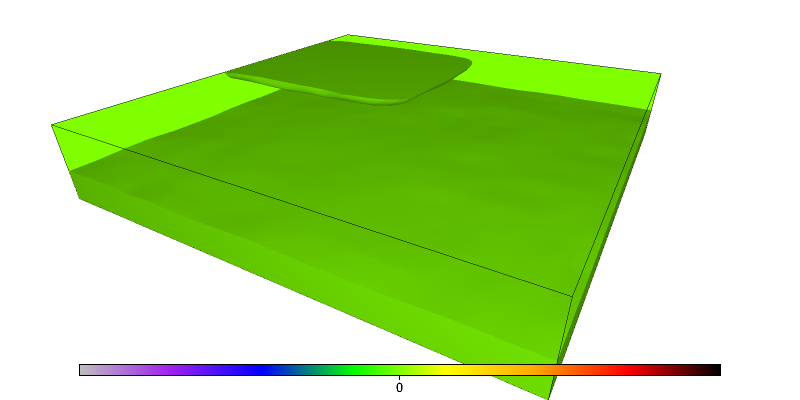

In [16]:
store = glucifer.Store(outputPath+'ozBench')
figMaterialStrain = glucifer.Figure( store, figsize=(800,400), name="MaterialStrain", facecolour='white', quality=2 )

#When plotting an isosurface, a second function can be passed to colour the surface
surf = figMaterialStrain.IsoSurface( mesh, materialField, strainRate_2ndInvariant,
                                     isovalues=[0.5], isowalls=True,
                                     colours='grey Purple Blue Green Yellow Orange Red Black')

#figMaterialStrain.Points(swarm, fn_colour = strainRate_2ndInvariant, 
#                          fn_mask   = materialFilter, 
#                          pointSize=2, #fn_size   = 2., 
#                          colours   = 'grey Purple Blue Green Yellow Orange Red Black' )

#Cross sections at the boundaries, use the same colour map as isosurface
figMaterialStrain.Surface( mesh, strainRate_2ndInvariant, crossSection="x 100%", colourMap=surf.colourMap, colourBar=False)
figMaterialStrain.Surface( mesh, strainRate_2ndInvariant, crossSection="z 0%", colourMap=surf.colourMap, colourBar=False)

#Apply the camera script
sc = figMaterialStrain.script(camera)

figMaterialStrain.show()

**Checkpointing funtion**

In [17]:
def checkpoint():
    swarm.save(            outputPath+'trenchSwarm.'  + str(step).zfill(5) +'.h5')
    materialVariable.save( outputPath+'materialIndex.'+ str(step).zfill(5) +'.h5')
    meshHnd = mesh.save(   outputPath+'mesh.'         + str(step).zfill(5) +'.h5')
    velocityField.save(    outputPath+'velocityField.'+ str(step).zfill(5) +'.h5', meshHnd)
    pressureField.save(    outputPath+'pressureField.'+ str(step).zfill(5) +'.h5', meshHnd)

**Update function**

In [18]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect using this timestep size.
    advector.integrate(dt)
   
    return time+dt, step+1

Main simulation loop
=======

The main time stepping loop begins here. Inside the time loop the velocity field is solved for via the Stokes system solver and then the swarm is advected using the advector integrator. Basic statistics are output to screen each timestep.

In [19]:
time = 0.  # Initial time
step = 0   # Initial timestep
maxSteps = 2      # Maximum timesteps (301 is recommended)
steps_output = 1  # output every 1 timesteps, increase for high resolution

In [20]:
while step <= maxSteps:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True)
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        #Important to set the timestep for the store object here or will overwrite previous step
        store.step = step
        figMaterialStrain.save()
        
        Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
        print 'step = {0:6d}; time = {1:.3e}; Vrms = {2:.3e}'.format(step,time,Vrms)
        checkpoint()

    time,step = update()

step =      0; time = 0.000e+00; Vrms = 1.633e-05
step =      1; time = 5.465e+02; Vrms = 1.699e-05
step =      2; time = 1.001e+03; Vrms = 1.740e-05



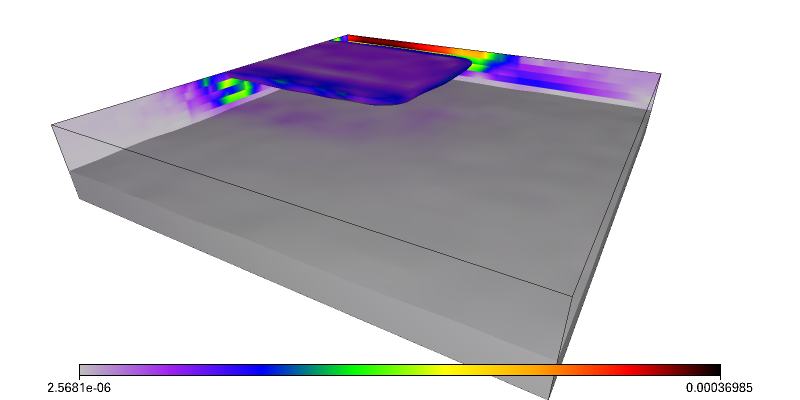

In [21]:
figMaterialStrain.show()